<h1><center>Front-end / Features</center></h1>

## Dataset description

### Free Spoken Digit Dataset (FSDD)

* 500 recordings in total (50 per digit)
* 8kHz sampling rate
* 1 speaker
* English 
* File format -> {digit\_label}\_{speaker\_name}\_{index}.wav <br>
    e.g. "4\_jackson\_16.wav"

Details: https://github.com/Jakobovski/free-spoken-digit-dataset

In [1]:
import glob
import os
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

%matplotlib inline

//anaconda/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Matplotlib styling
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'

## Extract sound filenames

In [3]:
# Dataset folder 
SOUND_FOLDER = "/Users/alparslan/Documents/WorkingSpace/python/digit-audio/dataset/"

# Create a list of all sound file paths
sound_paths = [SOUND_FOLDER + f for f in os.listdir(SOUND_FOLDER) if f[-4:] == '.wav']

## Data visualization

In [4]:
##################################################
#           Auxiliary functions                  #
##################################################

def load_sound_files(file_paths):
    return [librosa.load(fp)[0] for fp in file_paths]

def plot_wave(sound_name_with_raw_data):
    i = 1
    plt.figure(figsize=(15, 2 * len(sound_name_with_raw_data) if len(sound_name_with_raw_data) > 1 else 4))
    for n,d in sound_name_with_raw_data:
        plt.subplot(np.ceil(float(len(sound_name_with_raw_data))/2), 2, i)
        
        # wave plot
        librosa.display.waveplot(np.array(d),sr=8000)
        
        plt.ylabel('Amplitude')
        plt.title(n)
        i += 1
    plt.subplots_adjust(top=0.8, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()
    
def plot_spectrogram(sound_name_with_raw_data):
    i = 1
    plt.figure(figsize=(15, 2 * len(sound_name_with_raw_data) if len(sound_name_with_raw_data) > 1 else 4))
    for n,d in sound_name_with_raw_data:
        plt.subplot(np.ceil(float(len(sound_name_with_raw_data))/2), 2, i)
        
        # Spectrogram
        specgram(np.array(d), Fs=8000)
        
        plt.title(n)
        i += 1
    plt.subplots_adjust(top=0.8, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

def plot_log_power_spectrogram(sound_name_with_raw_data):
    i = 1
    plt.figure(figsize=(15, 2 * len(sound_name_with_raw_data) if len(sound_name_with_raw_data) > 1 else 4))
    for n,d in sound_name_with_raw_data:
        plt.subplot(np.ceil(float(len(sound_name_with_raw_data))/2), 2, i)
        
        # Log power spectrogram
        D = librosa.logamplitude(np.abs(librosa.stft(d))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        
        plt.title(n)
        i += 1
    plt.subplots_adjust(top=0.8, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

### Load sound files used in visualization

In [13]:
# Target sound filenames for visualization
sound_filenames = [str(i) + '_jackson_0.wav' for i in range(0, 10)]

# Load sound files used in visualization
sound_name_with_raw_data = [("Digit " + os.path.basename(p)[0], librosa.load(p)[0]) for i, p in enumerate(sound_paths) if os.path.basename(p) in sound_filenames]

### Plots

<h4><center>Fig. I. Speech Pressure Wave plot</center></h4>

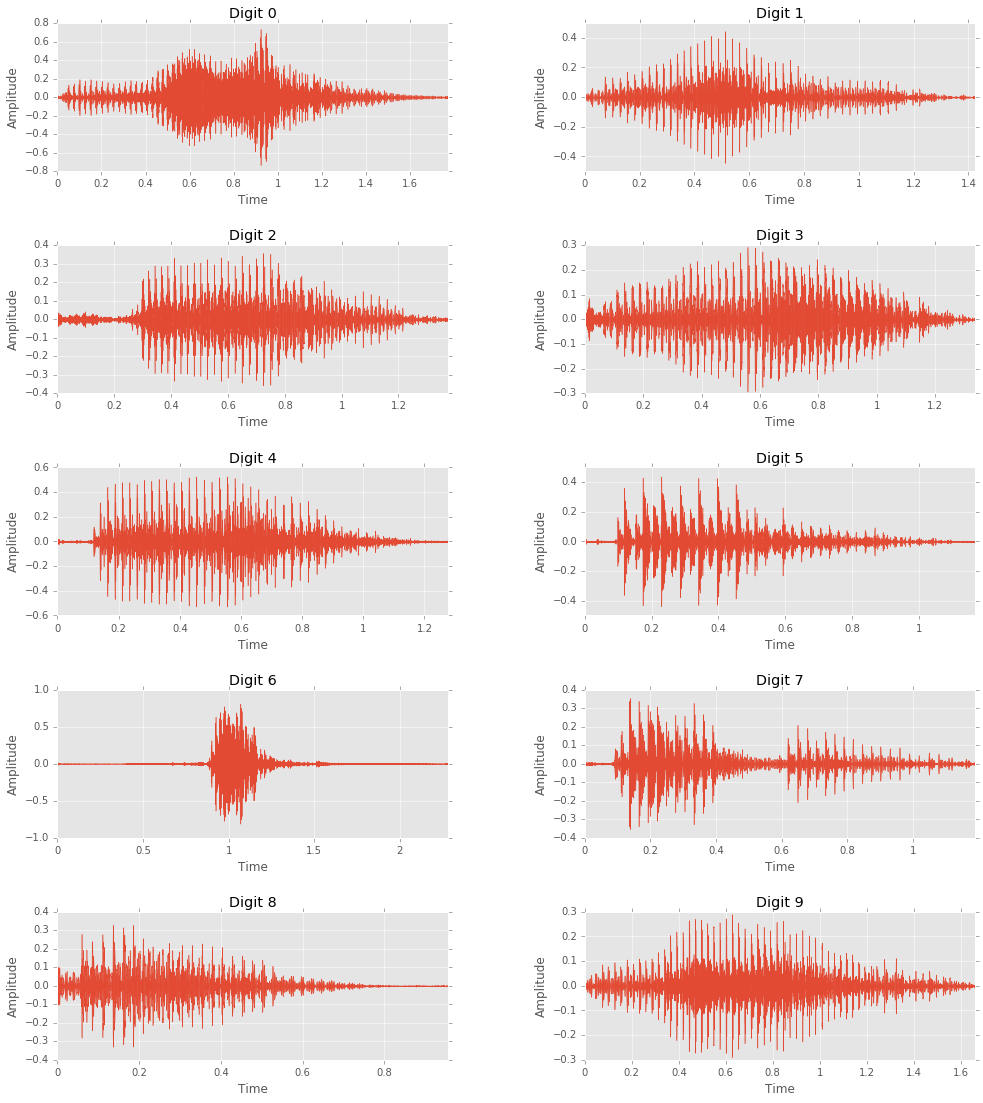

In [14]:
plot_wave(sound_name_with_raw_data)

<h4><center>Fig. II. Spectrogram</center></h4>

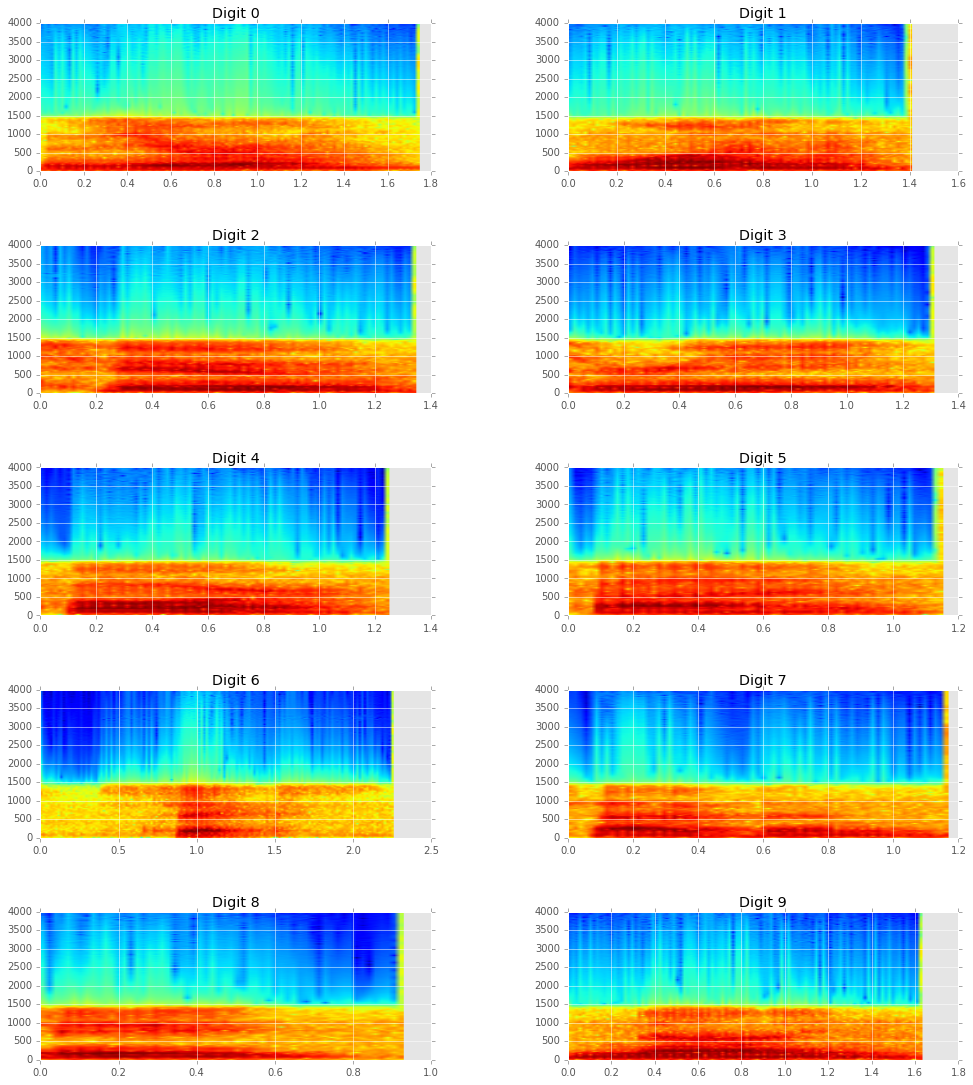

In [169]:
plot_spectrogram(sound_name_with_raw_data)

<h4><center>Fig. III. Log Power Spectrogram</center></h4>

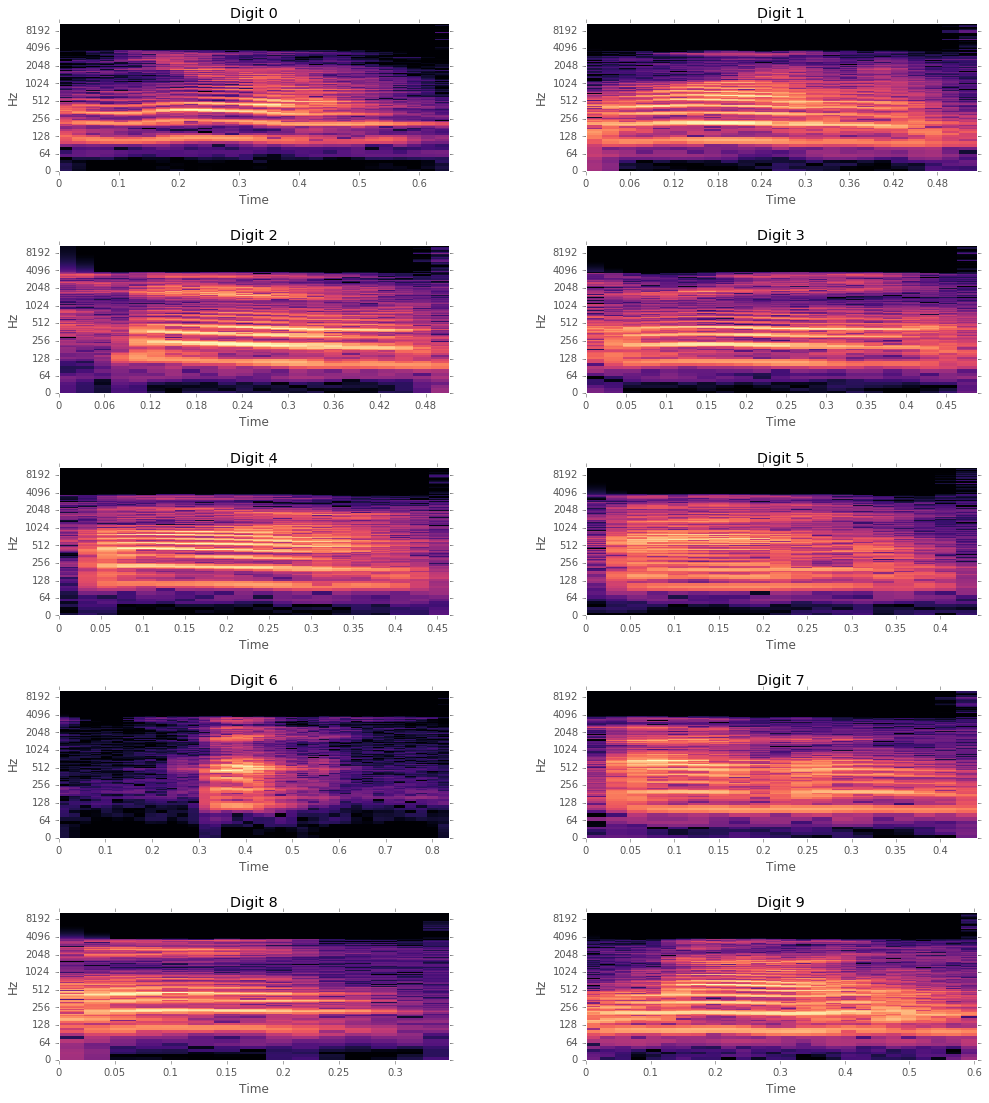

In [173]:
plot_log_power_spectrogram(sound_name_with_raw_data)

## Feature extraction

In [176]:
##################################################
#           Auxiliary functions                  #
##################################################

def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def get_features_and_labels(sound_paths):
    features, labels = np.empty((0,193)), np.empty(0)
    for p in sound_paths:
        mfccs, chroma, mel, contrast,tonnetz = extract_feature(p)
        ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        features = np.vstack([features,ext_features])
        labels = np.append(labels, int(os.path.basename(p)[0]))
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

### Extract feature vectors and prepare labels

In [177]:
features, labels = get_features_and_labels(sound_paths)
labels = one_hot_encode(labels)

### Save  on disk

In [187]:
FEATURE_PATH = 'front-end/features.npy'
LABEL_PATH = 'front-end/labels.npy'

In [188]:
np.save(FEATURE_PATH, features)
np.save(LABEL_PATH, labels)